<a href="https://colab.research.google.com/github/dushyant1singh1/skin-lesion-image-classification/blob/main/main_project_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total train dataset has 1590 images<br>
We will split the train labels according to the numbers of each class
Classes:<br>
  0 - seborrheic keratosis (476 images)<br>
  1 - melanoma (595 images)<br>
  2 - nevus (519 images)<br>

Dataset is available in google drive folder 'data' 

In the dataset not all images are of same size<br>
For that we have to preprocess all the images<br>
We will use open cv library cv2 for this<br>
down below is demonstration of how the resize will affect the image

In [ ]:
data_url="/content/drive/My Drive/train"
val_url="/content/drive/My Drive/val"
test_url="/content/drive/My Drive/test"
train_data=tf.keras.preprocessing.image_dataset_from_directory(data_url,image_size=(256,256),batch_size=40,validation_split=0.1,subset='training',seed=123)
val_data=tf.keras.preprocessing.image_dataset_from_directory(data_url,image_size=(256,256),subset='validation',batch_size=1,validation_split=0.1,seed=123)
# test_data=tf.keras.preprocessing.image_dataset_from_directory(test_url,image_size=(256,256))

Found 1590 files belonging to 3 classes.
Using 1431 files for training.
Found 1590 files belonging to 3 classes.
Using 159 files for validation.


In [ ]:

image=cv2.imread(test_url+'/melanoma/'+)

In [ ]:
test_data_li=[]
test_label_li=[]

li=['melanoma','nevus','seb']
for folder in li:
  test_data_dir=os.listdir(test_url+'/'+folder)
  #print(test_data_dir)
  for name in test_data_dir:
    path=test_url+'/'+folder+'/'+name
    image=cv2.imread(path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
    test_data_li.append(image)
    if folder=='melanoma':
      test_label_li.append(0)
    elif folder=='nevus':
      test_label_li.append(1)
    else :
      test_label_li.append(2)
test_data_arr=np.array(test_data_li)
test_label_arr=np.array(test_label_li)

In [ ]:
print(len(test_data_arr))
print(len(test_label_arr))
print(test_label_arr)

36
36
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
print(train_data.class_names)
print(val_data.class_names)

['melanoma', 'nevus', 'seb']
['melanoma', 'nevus', 'seb']


In [ ]:
def building_model(opt):
  numclass=3
  model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.Conv2D(64,1,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(numclass,activation='softmax')
  ]
  )
  model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,metrics=['accuracy'])
   
  return model

In [ ]:
def gpu(model,epoch):
  with tf.device('/device:GPU:0'):
      hist = model.fit(train_data,validation_data=val_data,epochs=epoch)
      model_df=pd.DataFrame(hist.history)
      model_df['epoch']=hist.epoch   
  return model,model_df

In [ ]:
optimizers=['sgd','rmsprop','adam','adagrad','adadelta'] 

In [ ]:
import pandas as pd
def plotting(model_df):
  plt.figure(1)
  plt.plot(model_df['epoch'],model_df['loss'],label='training loss')
  plt.plot(model_df['epoch'],model_df['val_loss'],label='validation loss')
  plt.legend()
  plt.figure(2)
  plt.plot(model_df['epoch'],model_df['accuracy'],label='training accuracy')
  plt.plot(model_df['epoch'],model_df['val_accuracy'],label='validation accuracy')
  plt.legend()


**SGD - Stochastic Gradient Descent**
Advantages: 

In [ ]:
model_sgd=building_model(optimizers[0])#optimizers = sgd
nmodel_sgd,model_df_sgd=gpu(model_sgd,3)
#plot_model(nmodel_sgd,to_file='/content/drive/My Drive/model.png',show_shapes=True)

Epoch 1/3
36/36 [==============================] - 496s 14s/step - loss: 1.0988 - accuracy: 0.3305 - val_loss: 1.0985 - val_accuracy: 0.3836
Epoch 2/3
36/36 [==============================] - 7s 191ms/step - loss: 1.0981 - accuracy: 0.3564 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 3/3
36/36 [==============================] - 7s 186ms/step - loss: 1.0973 - accuracy: 0.3662 - val_loss: 1.0973 - val_accuracy: 0.4025


In [ ]:
results=model_sgd.evaluate(test_data_arr,test_label_arr)
print(results)
predictions=model_sgd.predict(test_data_arr)
predicted=

2/2 [==============================] - 0s 4ms/step - loss: 1.0976 - accuracy: 0.3333
[1.0976457595825195, 0.3333333432674408]
[[0.3536557  0.33267596 0.31366837]
 [0.3543406  0.3330856  0.31257376]
 [0.35894305 0.33238405 0.30867293]
 [0.3592471  0.33178368 0.30896917]
 [0.35608318 0.33302048 0.3108963 ]
 [0.35510173 0.33243155 0.31246674]
 [0.35940832 0.3323408  0.30825087]
 [0.3600463  0.33185932 0.30809435]
 [0.35907704 0.3321728  0.30875012]
 [0.35229897 0.33661854 0.31108254]
 [0.3632745  0.33115312 0.3055724 ]
 [0.35652548 0.33269367 0.31078085]
 [0.35176    0.33386168 0.31437835]
 [0.35926753 0.3318653  0.30886716]
 [0.35205385 0.3334923  0.3144539 ]
 [0.36123392 0.33166674 0.30709934]
 [0.35789466 0.33214617 0.30995917]
 [0.3532879  0.33456588 0.31214622]
 [0.34886748 0.33593088 0.3152016 ]
 [0.3575446  0.33192876 0.31052664]
 [0.3508946  0.33514568 0.31395975]
 [0.35943517 0.33245286 0.30811194]
 [0.35083595 0.33522052 0.31394356]
 [0.35882366 0.3325283  0.30864802]
 [0.356166

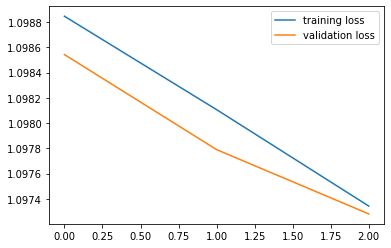

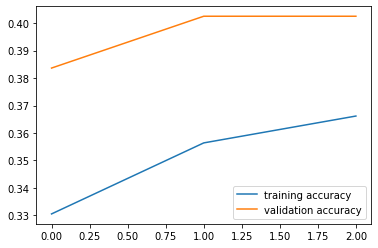

In [ ]:

plotting(model_df_sgd)

**RMSPROP**

Epoch 1/40
36/36 [==============================] - 12s 330ms/step - loss: 1.0977 - accuracy: 0.3557 - val_loss: 1.0928 - val_accuracy: 0.4025
Epoch 2/40
36/36 [==============================] - 12s 321ms/step - loss: 1.0797 - accuracy: 0.3969 - val_loss: 1.0381 - val_accuracy: 0.4780
Epoch 3/40
36/36 [==============================] - 12s 321ms/step - loss: 1.0295 - accuracy: 0.4738 - val_loss: 0.9676 - val_accuracy: 0.5912
Epoch 4/40
36/36 [==============================] - 12s 322ms/step - loss: 0.9850 - accuracy: 0.5045 - val_loss: 0.9750 - val_accuracy: 0.5157
Epoch 5/40
36/36 [==============================] - 12s 320ms/step - loss: 0.9633 - accuracy: 0.5269 - val_loss: 0.8789 - val_accuracy: 0.6730
Epoch 6/40
36/36 [==============================] - 11s 319ms/step - loss: 0.9476 - accuracy: 0.5430 - val_loss: 0.9112 - val_accuracy: 0.5786
Epoch 7/40
36/36 [==============================] - 12s 319ms/step - loss: 0.9560 - accuracy: 0.5472 - val_loss: 0.8865 - val_accuracy: 0.6415

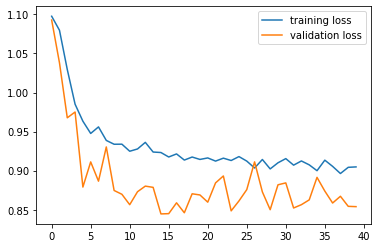

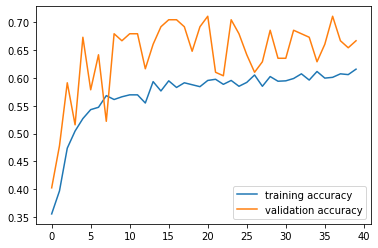

In [ ]:
model_rmsprop=building_model(optimizers[1])#optimizers = rmsprop
nmodel_rmsprop,model_df_rmsprop=gpu(model_rmsprop,40)
plotting(model_df_rmsprop)

**ADAM**

Epoch 1/40
36/36 [==============================] - 12s 323ms/step - loss: 1.0985 - accuracy: 0.3662 - val_loss: 1.0949 - val_accuracy: 0.4025
Epoch 2/40
36/36 [==============================] - 12s 331ms/step - loss: 1.0870 - accuracy: 0.3711 - val_loss: 1.0598 - val_accuracy: 0.4025
Epoch 3/40
36/36 [==============================] - 12s 323ms/step - loss: 1.0557 - accuracy: 0.4598 - val_loss: 1.0179 - val_accuracy: 0.5220
Epoch 4/40
36/36 [==============================] - 12s 321ms/step - loss: 0.9798 - accuracy: 0.5332 - val_loss: 0.9854 - val_accuracy: 0.5031
Epoch 5/40
36/36 [==============================] - 11s 319ms/step - loss: 1.0042 - accuracy: 0.4997 - val_loss: 1.0224 - val_accuracy: 0.4654
Epoch 6/40
36/36 [==============================] - 11s 318ms/step - loss: 0.9783 - accuracy: 0.5255 - val_loss: 0.9280 - val_accuracy: 0.5660
Epoch 7/40
36/36 [==============================] - 11s 319ms/step - loss: 0.9500 - accuracy: 0.5367 - val_loss: 0.9421 - val_accuracy: 0.5912

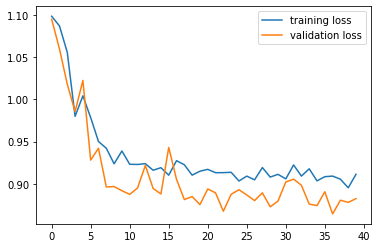

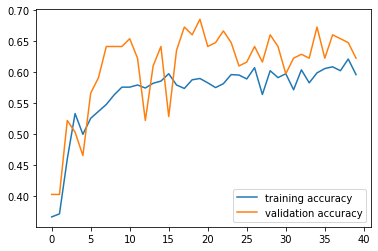

In [ ]:
model_adam=building_model(optimizers[2])#optimizers = adam
nmodel_adam,model_df_adam=gpu(model_adam,40)
plotting(model_df_adam)

**ADAGRAD**

Epoch 1/40
36/36 [==============================] - 12s 326ms/step - loss: 1.0971 - accuracy: 0.3571 - val_loss: 1.0980 - val_accuracy: 0.3082
Epoch 2/40
36/36 [==============================] - 12s 320ms/step - loss: 1.0961 - accuracy: 0.3606 - val_loss: 1.0976 - val_accuracy: 0.3962
Epoch 3/40
36/36 [==============================] - 11s 318ms/step - loss: 1.0958 - accuracy: 0.3571 - val_loss: 1.0972 - val_accuracy: 0.4025
Epoch 4/40
36/36 [==============================] - 11s 319ms/step - loss: 1.0956 - accuracy: 0.3669 - val_loss: 1.0969 - val_accuracy: 0.4025
Epoch 5/40
36/36 [==============================] - 12s 320ms/step - loss: 1.0950 - accuracy: 0.3669 - val_loss: 1.0967 - val_accuracy: 0.4025
Epoch 6/40
36/36 [==============================] - 12s 332ms/step - loss: 1.0949 - accuracy: 0.3620 - val_loss: 1.0964 - val_accuracy: 0.4025
Epoch 7/40
36/36 [==============================] - 11s 316ms/step - loss: 1.0942 - accuracy: 0.3704 - val_loss: 1.0961 - val_accuracy: 0.4025

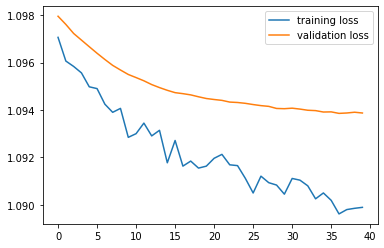

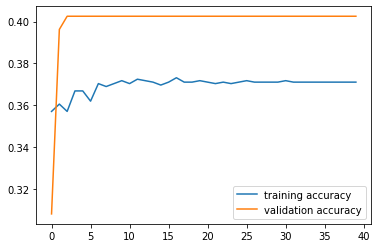

In [ ]:
model_adagrad=building_model(optimizers[3])#optimizers = adagrad
nmodel_adagrad,model_df_adagrad=gpu(model_adagrad,40)
plotting(model_df_adagrad)

**ADADELTA**

Epoch 1/40
36/36 [==============================] - 12s 338ms/step - loss: 1.0970 - accuracy: 0.3494 - val_loss: 1.0988 - val_accuracy: 0.2830
Epoch 2/40
36/36 [==============================] - 11s 317ms/step - loss: 1.0970 - accuracy: 0.3522 - val_loss: 1.0988 - val_accuracy: 0.2830
Epoch 3/40
36/36 [==============================] - 11s 316ms/step - loss: 1.0973 - accuracy: 0.3340 - val_loss: 1.0987 - val_accuracy: 0.2830
Epoch 4/40
36/36 [==============================] - 11s 316ms/step - loss: 1.0967 - accuracy: 0.3669 - val_loss: 1.0987 - val_accuracy: 0.2830
Epoch 5/40
36/36 [==============================] - 11s 317ms/step - loss: 1.0968 - accuracy: 0.3760 - val_loss: 1.0987 - val_accuracy: 0.2642
Epoch 6/40
36/36 [==============================] - 11s 316ms/step - loss: 1.0970 - accuracy: 0.3354 - val_loss: 1.0987 - val_accuracy: 0.2579
Epoch 7/40
36/36 [==============================] - 11s 319ms/step - loss: 1.0964 - accuracy: 0.3788 - val_loss: 1.0987 - val_accuracy: 0.2264

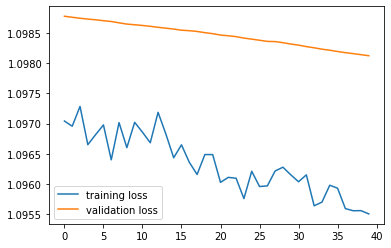

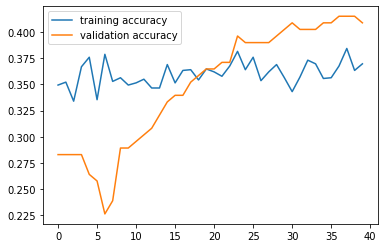

In [ ]:
model_adadelta=building_model(optimizers[4])#optimizers = adadelta
nmodel_adadelta,model_df_adadelta=gpu(model_adadelta,40)
plotting(model_df_adadelta)